# http://uc-r.github.io/gbm_regression
Whereas random forests build an ensemble of deep independent trees, GBMs build an ensemble of shallow and weak successive trees with each tree learning and improving on the previous. 

In [1]:
library(rsample)      # data splitting 
library(gbm)          # basic implementation
library(xgboost)      # a faster implementation of gbm
library(caret)        # an aggregator package for performing many machine learning models
library(h2o)          # a java-based platform
library(pdp)          # model visualization
library(ggplot2)      # model visualization
library(lime)         # model visualization

Loaded gbm 2.1.8

Loading required package: lattice

Loading required package: ggplot2


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: 'h2o'


The following objects are masked from 'package:stats':

    cor, sd, var


The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




# https://datascienceplus.com/gradient-boosting-in-r/
Boosting is a sequential process in which each next model which is generated is added so as to improve a bit from the previous collection of models. In Boosting we do weighted averaging. 
Boosting is leans more towards Bias i.e simple learners or more specifically Weak learners. A weak learner is a learner which always learns something i.e does better than chance and also has error rate less then 50%. The best example of a weak learner is a Decision tree, and is why we generally use decision trees to improve accuracy and performance.

## import data and check data attributes (NAs, column d_types, etc.)

In [2]:
ml_data <- read.csv('ml_predict_data.csv')

In [3]:
# assign countyname col to ml_data idx
row.names(ml_data) <- ml_data$X
# drop X col
drops <- c('X')
ml_data <- ml_data[, !(names(ml_data) %in% drops)]

In [4]:
set.seed(1)  # for reproducibility

# create index for testing and training data
inTrain <- createDataPartition(y = ml_data$avg_perc_change, p = 0.7, list = FALSE)

# subset ml_data to train
training <- ml_data[inTrain,]

# subset the rest to test
testing <- ml_data[-inTrain,]

## hyperparameter tuning

In [28]:
# create hyperparameter grid
hyper_grid <- expand.grid(
  shrinkage = c(.15, .2, .25),
  interaction.depth = c(3, 4, 5),
  n.minobsinnode = c(15, 20, 25),
  bag.fraction = c(.75, .8, .85), 
  optimal_trees = 0,               # a place to dump results
  min_RMSE = 0                     # a place to dump results
)

# total number of combinations
nrow(hyper_grid)

[1] 54

## grid search
0.20	4	15	0.85	7	 -> 0.1531915

In [29]:
# randomize data
random_index <- sample(1:nrow(ml_data), nrow(ml_data))
random_employ_train <- ml_data[random_index, ]

# grid search 
for(i in 1:nrow(hyper_grid)) {
  
  # reproducibility
  set.seed(1)
  
  # train model
  gbm.tune <- gbm(
    formula = avg_perc_change ~ .,
    distribution = "gaussian",
    data = random_employ_train,
    n.trees = 9000,
    interaction.depth = hyper_grid$interaction.depth[i],
    shrinkage = hyper_grid$shrinkage[i],
    n.minobsinnode = hyper_grid$n.minobsinnode[i],
    bag.fraction = hyper_grid$bag.fraction[i],
    train.fraction = .75,
    n.cores = NULL, # will use all cores by default
    verbose = FALSE
  )
  
  # add min training error and trees to grid
  hyper_grid$optimal_trees[i] <- which.min(gbm.tune$valid.error)
  hyper_grid$min_RMSE[i] <- sqrt(min(gbm.tune$valid.error))
}

hyper_grid %>% 
  dplyr::arrange(min_RMSE) %>%
  head(10)

,shrinkage,interaction.depth,n.minobsinnode,bag.fraction,optimal_trees,min_RMSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.25,5,20,0.85,10,0.1634605
2,0.15,4,15,0.75,19,0.1635547
3,0.15,4,20,0.75,25,0.1637474
4,0.15,3,20,0.75,19,0.1642755
5,0.15,5,20,0.75,19,0.1644436
6,0.20,3,20,0.75,18,0.1651799
7,0.15,5,15,0.75,19,0.1654742
8,0.15,3,15,0.75,19,0.1654746
9,0.15,5,15,0.85,23,0.1655253


## train the gradient boosted model

In [30]:
gbm.fit.final = gbm(
    avg_perc_change ~ ., 
    data = training, 
    distribution = "gaussian",
    n.trees = 10000, # generates 10000 trees
    shrinkage = 0.2, # also a sort of learning rate
    interaction.depth = 4, # the total splits, each tree is a small tree with only 4 splits
    n.minobsinnode = 15,
    bag.fraction = 0.85,
    train.fraction = .75,
    cv.folds = 3,
    n.cores = NULL, # will use all cores by default
)

## Feature Importance Plot

,var,rel.inf
,<chr>,<dbl>
nonelder,nonelder,12.611336
new_case_count_sum,new_case_count_sum,10.377566
state,state,8.408010
religion,religion,7.267215
education,education,5.485675
employ,employ,5.219582
union,union,4.965628
genderincome,genderincome,4.897506
language,language,4.684064


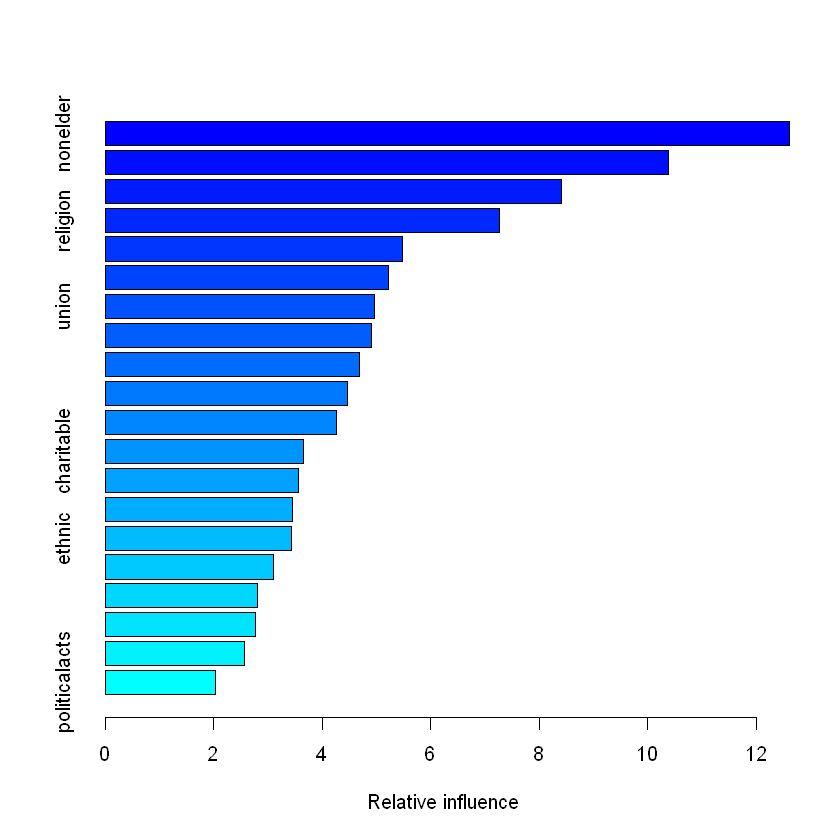

In [31]:
# summary gives a table of Variable Importance (from most to least important) and a plot of Variable Importance
summary(gbm.fit.final)

## Partial Dependence Plot
plots the average marginal effect on the response variable

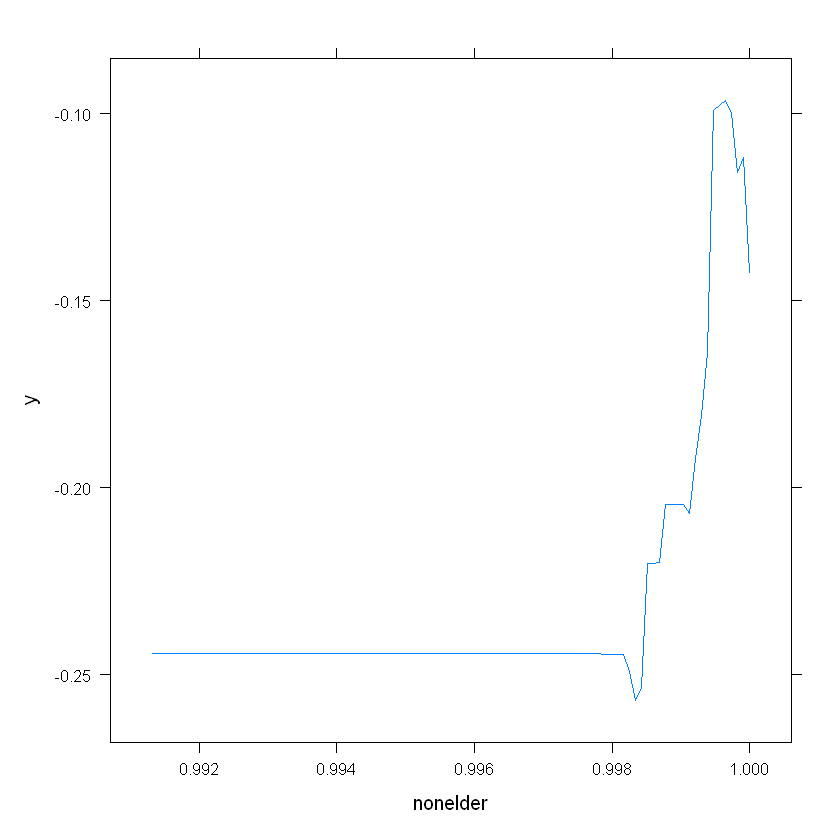

In [32]:
# Plot of Response variable with lstat variable
plot(gbm.fit.final,i="nonelder") 
# Inverse relation with avg_perc_change variable

In [8]:
cor(ml_data$avg_perc_change, ml_data$nonelder) # negetive correlation coeff-r

[1] 0.2176519

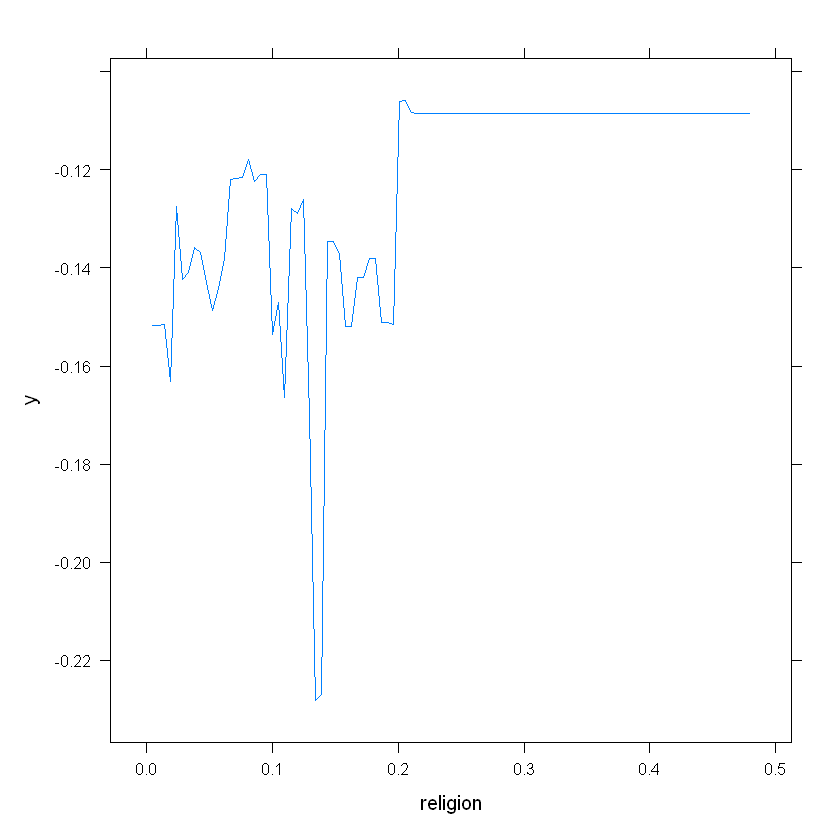

In [33]:
plot(gbm.fit.final,i="religion") 
# Inverse relation with avg_perc_change variable

In [10]:
cor(ml_data$avg_perc_change, ml_data$religion) # negetive correlation coeff-r

[1] -0.1565462

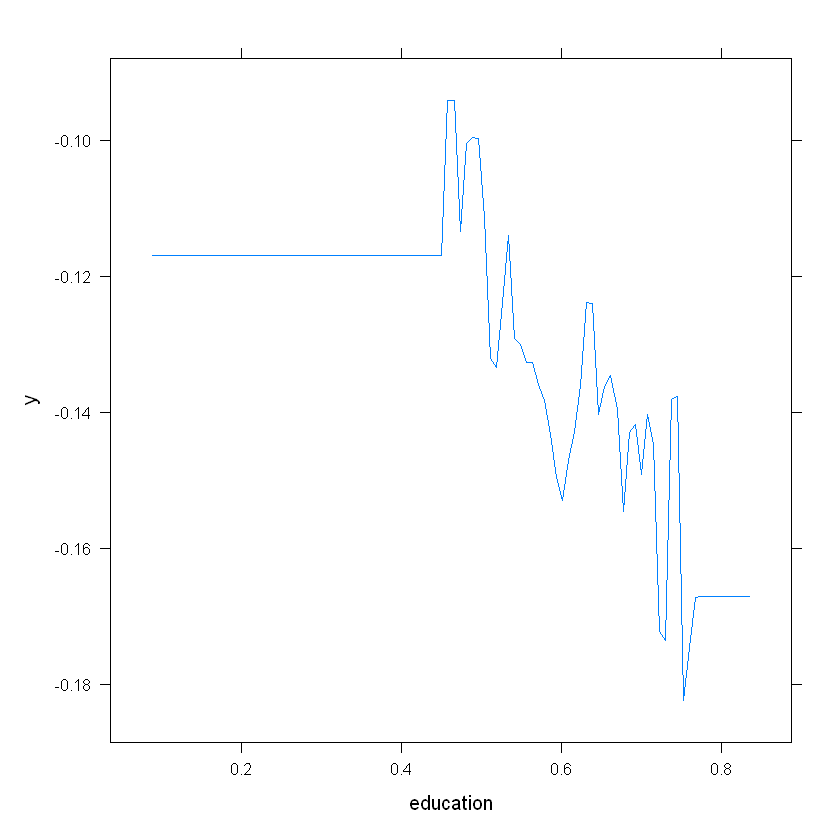

In [34]:
plot(gbm.fit.final,i="education") 
# Inverse relation with avg_perc_change variable

In [12]:
cor(ml_data$avg_perc_change, ml_data$education)# positive correlation coeff-r

[1] 0.06303116

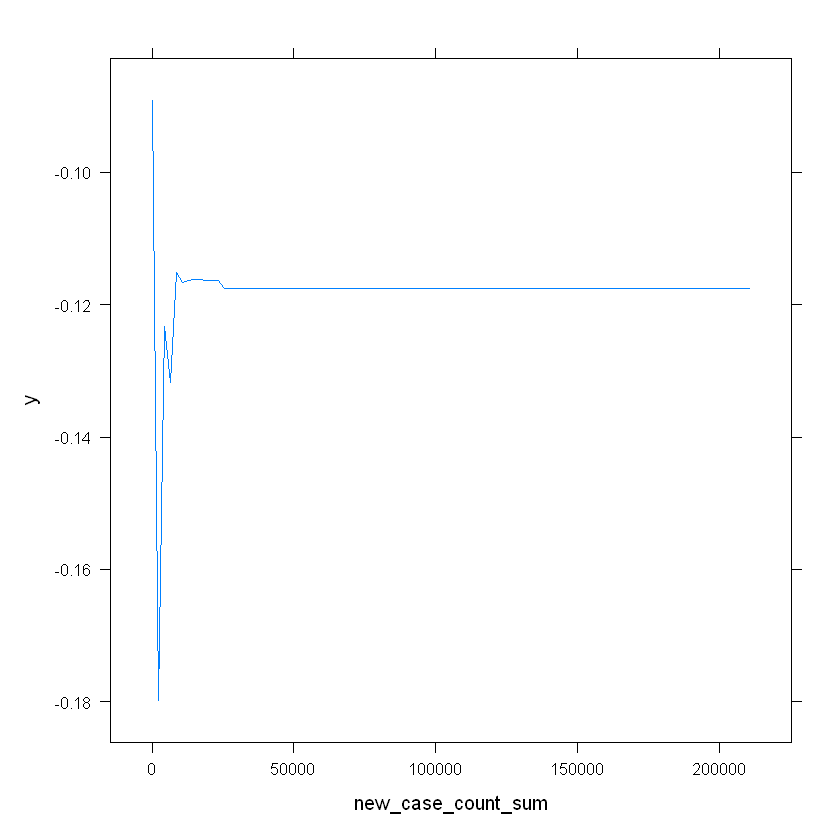

In [35]:
plot(gbm.fit.final,i="new_case_count_sum") 
# Inverse relation with avg_perc_change variable

In [14]:
cor(ml_data$avg_perc_change, ml_data$new_case_count_sum) # positive correlation coeff-r

[1] 0.006875771

## ICE Plot
plots the change in the predicted response variable for varied predictor variable values

Warning message:
"Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead."
Warning message:
"Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead."
Warning message:
"Use of `x.rug[[1L]]` is discouraged. Use `.data[[1L]]` instead."


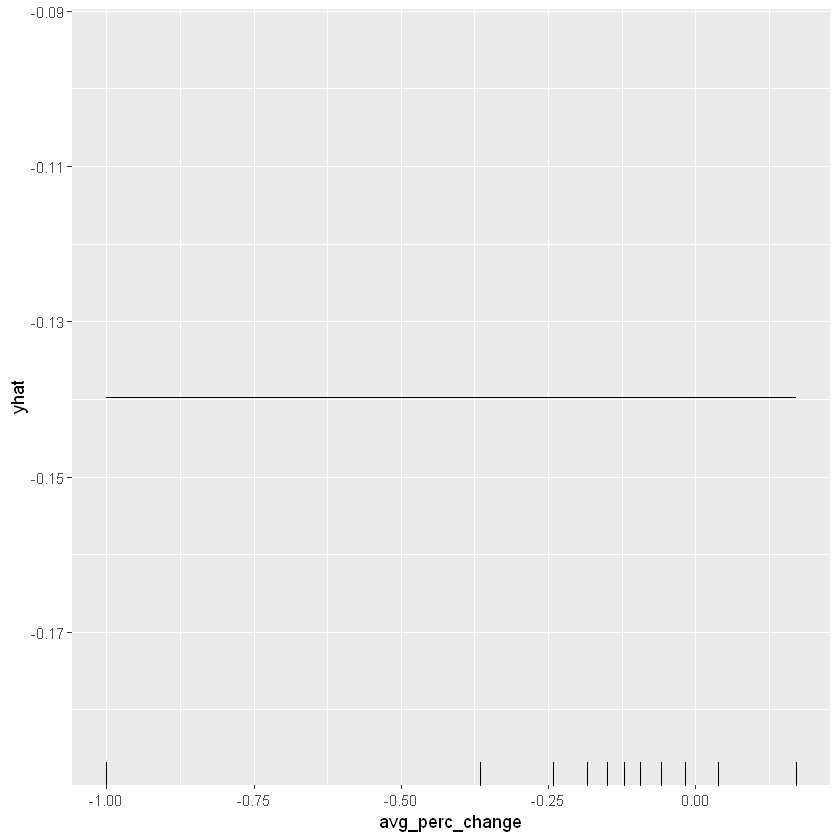

In [36]:
# gbm.fit.final %>%
#   partial(pred.var = "avg_perc_change", n.trees = gbm.fit.final$n.trees, grid.resolution = 100) %>%
#   autoplot(rug = TRUE, train = training) 
# # +
# #   scale_y_continuous(labels = scales::dollar)

### centered vs. non-centered

In [ ]:
# ice1 <- gbm.fit.final %>%
#   partial(
#     pred.var = "Gr_Liv_Area", 
#     n.trees = gbm.fit.final$n.trees, 
#     grid.resolution = 100,
#     ice = TRUE
#     ) %>%
#   autoplot(rug = TRUE, train = ames_train, alpha = .1) +
#   ggtitle("Non-centered") +
#   scale_y_continuous(labels = scales::dollar)

# ice2 <- gbm.fit.final %>%
#   partial(
#     pred.var = "Gr_Liv_Area", 
#     n.trees = gbm.fit.final$n.trees, 
#     grid.resolution = 100,
#     ice = TRUE
#     ) %>%
#   autoplot(rug = TRUE, train = ames_train, alpha = .1, center = TRUE) +
#   ggtitle("Centered") +
#   scale_y_continuous(labels = scales::dollar)

# gridExtra::grid.arrange(ice1, ice2, nrow = 1)

# making predictions

In [37]:
# predict values for test data
pred <- predict(gbm.fit.final, n.trees = gbm.fit.final$n.trees, testing)

## MSE

In [16]:
#Calculating The Mean squared Test Error
test.error<-with(testing,apply( (predmatrix-avg_perc_change)^2,2,mean))
head(test.error) #contains the Mean squared test error for each of the 100 trees averaged

100        150        200        250        300        350 
0.02317609 0.02296003 0.02275756 0.02258374 0.02243179 0.02228005

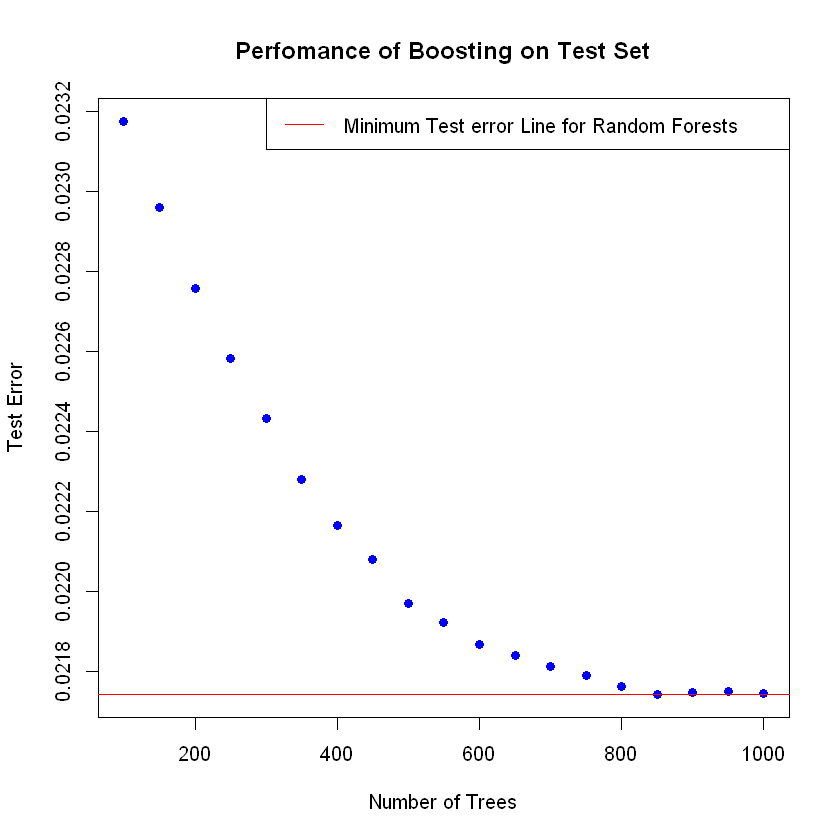

In [17]:
# Plotting the test error vs number of trees
plot(n.trees, test.error, pch = 19, col = "blue", xlab = "Number of Trees", ylab = "Test Error",
    main = "Perfomance of Boosting on Test Set")

# adding the RandomForests Minimum Error line trained on same data and similar
# parameters
abline(h = min(test.error), col = "red")  #test.err is the test error of a Random forest fitted on same data
legend("topright", c("Minimum Test error Line for Random Forests"), col = "red",
    lty = 1, lwd = 1)

If boosting is done properly, by selecting appropriate tuning parameters such as:
 - the shrinkage parameter (lambda)
 - the number of splits
 - the number of trees n

then it can generalize really well and convert a weak learner to strong learner. 

## RSME

## manual calculation

In [18]:
rmse = function(actual, predicted) {
  sqrt(mean((actual - predicted) ^ 2))
}

In [19]:
rmse(testing$avg_perc_change, predmatrix[,1])

[1] 0.1522369

## using caret package calculation

In [ ]:
# results
caret::RMSE(pred, testing$avg_perc_change)

## plot loss function as a result of n trees added to the ensemble

[1] 0.163039

[1] 1258

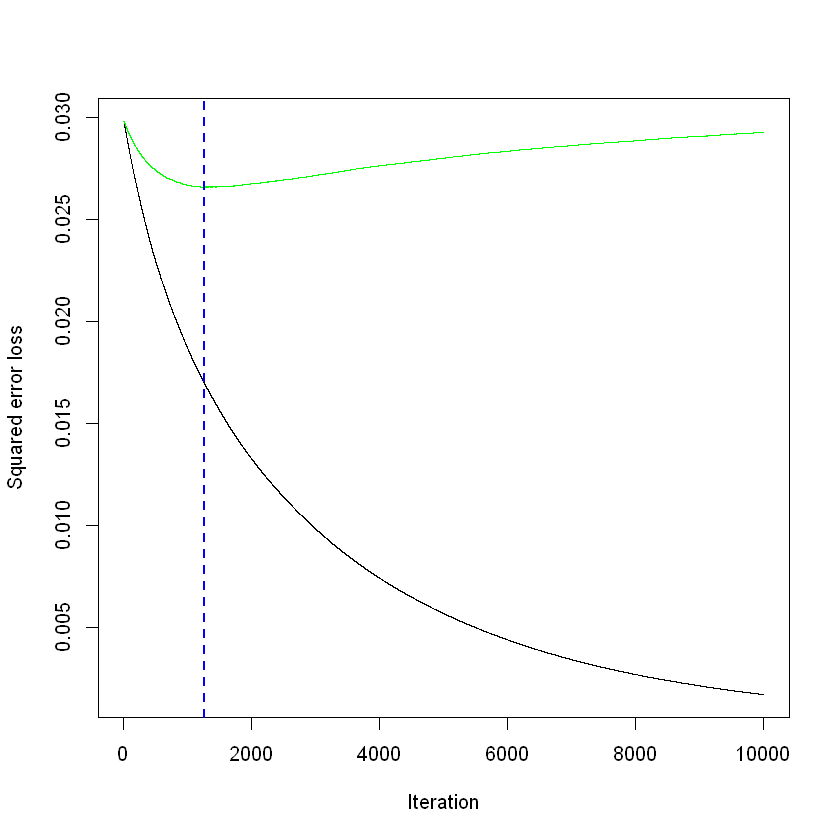

In [20]:
# get MSE and compute RMSE
sqrt(min(Employ.Boost$cv.error))
## [1] 29133.33

# plot loss function as a result of n trees added to the ensemble
gbm.perf(Employ.Boost, method = "cv")

# naive_roc_auc_score

In [38]:
naive_roc_auc_score <- function(y_true, y_pred) {
    num_same_sign <- 0
    num_pairs <- 0 
    
    for(a in 1:length(y_true))
    {
        for(b in 1:length(y_true))
        {
            if (y_true[a] > y_true[b]) {
                
                num_pairs <- num_pairs + 1
                
                if (y_pred[a] > y_pred[b]) {
                
                    num_same_sign <- num_same_sign + 1
                }
                else if (y_pred[a] == y_pred[b]) {
                    
                    num_same_sign <- num_same_sign + .5
                }
            }
        }
    }
    num_same_sign / num_pairs
}

In [39]:
naive_roc_auc_score(testing$avg_perc_change, pred)

[1] 0.5372151